### Class model with dropout

In [21]:
# warning message 제거

import warnings
warnings.filterwarnings(action='ignore')

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import random

In [23]:
from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

# loss 값 ploting 을 위해 사용
import matplotlib.pyplot as plt

Check GPU and fix the random seed

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


### Load Dataset and preprocessing

In [25]:
mnist = MNIST('./MNIST')
mnist.gz = True
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

# data 는 list 형식을 되어 있으므로 shape 을 보고, 이미지 visualization 을 하기 편한 array 형태로 바꾸어준다.

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

print("x_train 의 shape={}, y_train 의 shape={}".format(x_train.shape,y_train.shape))
print("x_test 의 shape={}, y_test 의 shape={}".format(x_test.shape,y_test.shape))

x_train 의 shape=(60000, 784), y_train 의 shape=(60000,)
x_test 의 shape=(10000, 784), y_test 의 shape=(10000,)


### Convert dataset into Tensor

In [26]:
batch_size = 1000
traindata = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
trainloader = data_utils.DataLoader(traindata, batch_size = batch_size ,shuffle = True)

In [27]:
# p – probability of an element to be zeroed. Default: 0.5 => 0으로 만들어줄 확률, 쉬운 이해를 위해 아래 예시를 참조
drop_prob1 = 0.4 # 40%는 out
drop_prob2 = 0.25 # 25%는 out

class Dropout(nn.Module):
    def __init__(self):
        super(Dropout, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.dp1 = nn.Dropout(p = drop_prob1)
        self.dp2 = nn.Dropout(p = drop_prob2)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h1dp = self.dp1(h1)
        
        h2 = F.relu(self.fc2(h1dp))
        h2dp = self.dp2(h2)
        
        output = self.fc3(h2dp)
            
        return output

model = Dropout().to(device)

In [28]:
model

Dropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dp1): Dropout(p=0.4, inplace=False)
  (dp2): Dropout(p=0.25, inplace=False)
)

### Set parameters

In [29]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

### Data Train

In [30]:
# model = Dropout().to(device)

loss_list = []

for epoch_num in range(epoch):
    model.train()
    average_loss = 0
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        num_of_mini_batch = len(trainloader)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predicted = model(images)
        
        labels_long = torch.tensor(labels, dtype = torch.long)
        labels_long = labels_long.to(device)
        
        loss = loss_function(predicted, labels_long)
        
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        average_loss += (loss.item()/num_of_mini_batch)
   
    print("Epoch = {}\tAverage loss = {}".format((epoch_num+1), average_loss))

Epoch = 1	Average loss = 7.05315877199173
Epoch = 2	Average loss = 2.022984604040782
Epoch = 3	Average loss = 1.7004256685574852
Epoch = 4	Average loss = 1.2707194805145263
Epoch = 5	Average loss = 0.9756577442089719
Epoch = 6	Average loss = 0.826453431447347
Epoch = 7	Average loss = 0.726645968357722
Epoch = 8	Average loss = 0.6483511755863824
Epoch = 9	Average loss = 0.5848774055639903
Epoch = 10	Average loss = 0.5330233708024025
Epoch = 11	Average loss = 0.5016288777192434
Epoch = 12	Average loss = 0.48526539603869123
Epoch = 13	Average loss = 0.4657049253582954
Epoch = 14	Average loss = 0.46473103215297074
Epoch = 15	Average loss = 0.45490695983171464


### Check 3rd Epoch average Loss

In [31]:
epoch_loss = 0
for i in range(60):
    epoch_loss = epoch_loss + loss_list[i+120]
    
print(epoch_loss/60)

1.700425668557485


In [32]:
# 60000개를 1000 배치로 나누었을때 60이 되므로 epoch 하나당 60 묶음의 배치가 학습이된다
# 15 epoch 이므로 900 묶음의 배치가 학습이 되게 되고 list 에 append 되는 loss value 도 900 개가 된다.
print("loss_list의 길이 =",len(loss_list))

loss_list의 길이 = 900


In [33]:
loss_list[:10]

[23.805875778198242,
 146.95936584472656,
 76.81898498535156,
 35.470550537109375,
 14.43237018585205,
 5.475516319274902,
 3.118227481842041,
 2.625511407852173,
 2.4763846397399902,
 2.33309268951416]

In [34]:
from matplotlib import pyplot as plt

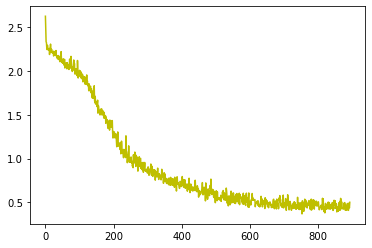

In [35]:
plt.plot(np.array(loss_list[7:]), 'y')

In [36]:
import pickle

# wb - 바이트 형식으로 저장

with open('Dropout.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

### Test code

In [37]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size = 5000, shuffle = False)

In [38]:
with torch.no_grad():
    model.eval()
    num_total_data = 0
    correct = 0
    
    for _, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        output_sftmax = F.softmax(output) # torch.nn.functional.softmax = F.softmax
        
        predicted = torch.argmax(output_sftmax, dim=1)
        
        num_total_data += len(images)
        
        answer = sum(labels == predicted).item()
        correct += answer
        
    print("Dropout 을 사용한 accuracy = %.2f%%" %((correct/num_total_data)*100))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 25.89 MiB already allocated; 0 bytes free; 30.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# drop_prob1 = 0.5
# drop_prob2 = 0.3 으로 설정해놓고 다시 돌려보자